In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from sklearn.decomposition import PCA
import matplotlib.cm as cm

In [2]:
from scipy.stats import pearsonr

# Arguments

In [17]:
internal_dim = 24
generic_exp_name = 'new_altT_eps0.4_tlen9_mlen5'
episode = 60
network_yaml = 'dm'

# Directories

In [18]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'
exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
analysis_dir = f'{engram_dir}analysis/{exp_name}/'

# Load analysis

In [19]:
with open(f'{analysis_dir}representation_df_ep{episode}.p', 'rb') as f:
    repr_df = pickle.load(f)

In [20]:
y_locs = np.sort(np.unique(repr_df['y']))
x_locs = np.sort(np.unique(repr_df['x']))
n_y = y_locs.size
midpoint = x_locs[x_locs.size//2]

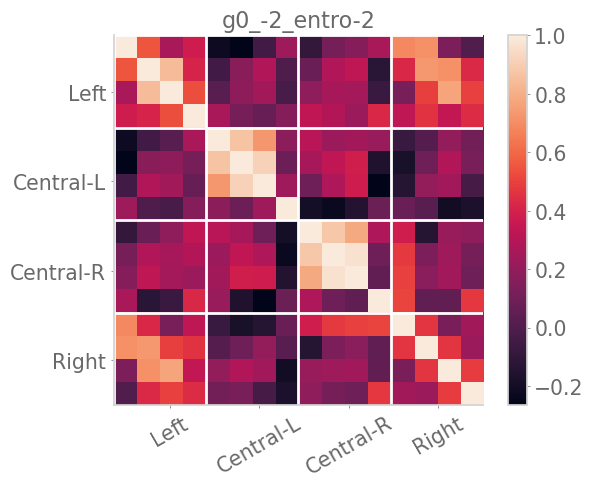

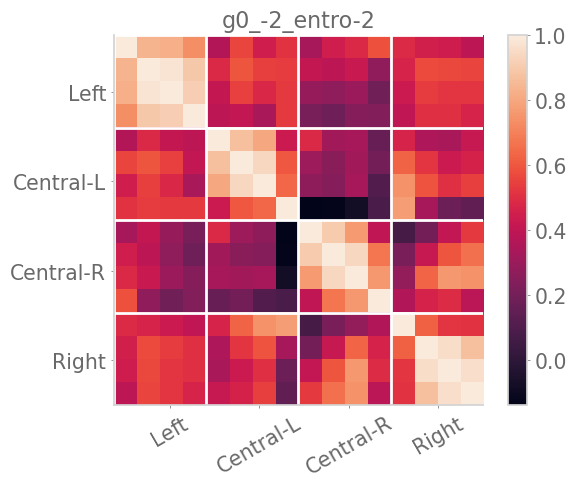

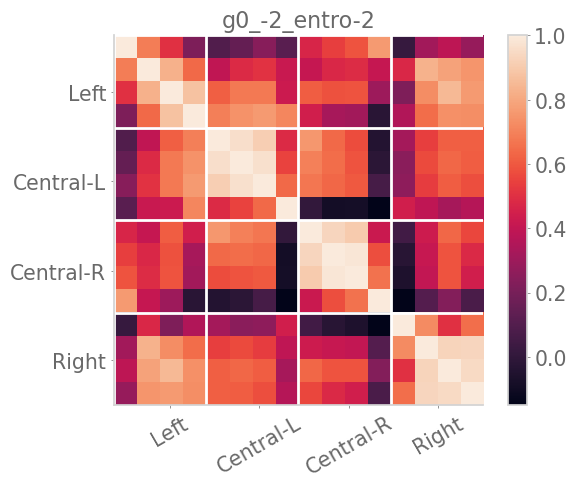

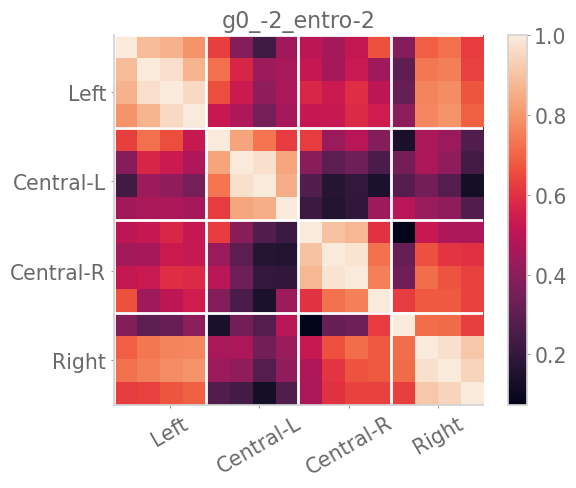

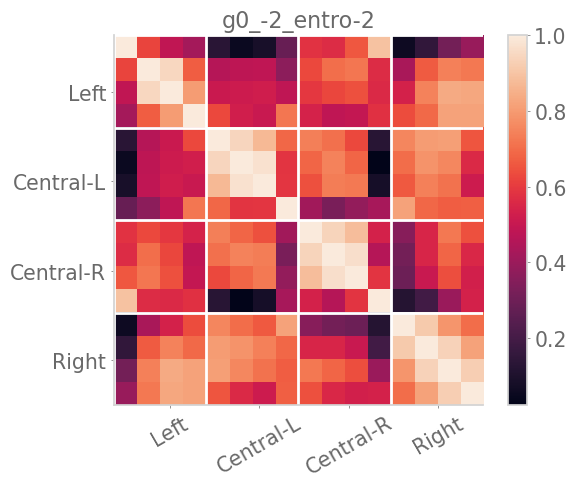

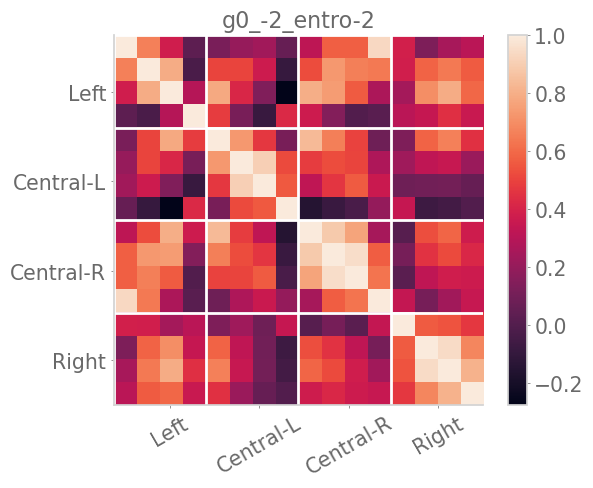

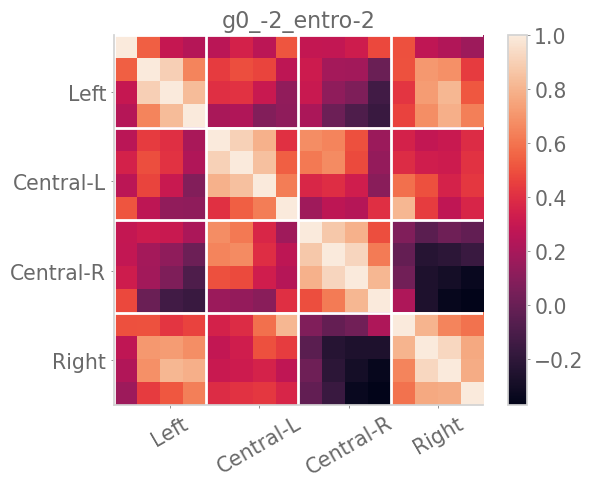

In [30]:
models = []
stem_locs = []
splits = []
iters = []

for model in np.unique(repr_df['model']):
    for iteration in np.unique(repr_df[repr_df['model']==model]['iteration']):
        # Initialize similarity matrix
        sim_mat = np.zeros((n_y*4, n_y*4))*np.nan
        
        # Partition dataset into the four desired conditions
        _df = repr_df[(repr_df['model']==model) & (repr_df['iteration']==iteration)]
        final_reward = _df['final_reward'].iloc[0]
        if final_reward < 90: continue
        _df_L = _df[_df['x']==x_locs[0]]
        _df_LReset = _df[(_df['x']==midpoint) & (_df['reward_loc']==2)]
        _df_RReset = _df[(_df['x']==midpoint) & (_df['reward_loc']==1)]
        _df_R = _df[_df['x']==x_locs[-1]]
        _df_list = [_df_L, _df_LReset, _df_RReset, _df_R]
        
        # Get pairwise differences
        for i, df_i in enumerate(_df_list):
            for j, df_j in enumerate(_df_list):
                if j > i: continue
                for y_i_idx, _y_i in enumerate(y_locs):
                    for y_j_idx, _y_j in enumerate(y_locs):
                        df_i_y = np.array((df_i[df_i['y']==_y_i]['latents']).tolist()).squeeze()
                        df_j_y = np.array((df_j[df_j['y']==_y_j]['latents']).tolist()).squeeze()
                        df_i_y = np.mean(df_i_y, axis=0)
                        df_j_y = np.mean(df_j_y, axis=0)
                        
                        #diff_norm = np.linalg.norm(df_i_y - df_j_y) # Norm difference
                        diff_norm, _ = pearsonr(df_i_y, df_j_y) # Pearsonr
                        sim_mat[y_i_idx + i*n_y, y_j_idx + j*n_y] = diff_norm
                        sim_mat[y_j_idx + j*n_y, y_i_idx + i*n_y] = diff_norm
        models.extend([model]*n_y)
        stem_locs.extend(range(n_y))
        reset_mat = sim_mat[n_y:2*n_y, 2*n_y:3*n_y]
        diag = np.diag(reset_mat)
        splits.extend(diag.tolist())
        iters.extend([iteration]*n_y)
                        
        plt.figure()
        plt.title(model)
        height = y_locs.size
        plt.imshow(sim_mat)#, vmin=0, vmax=0.9)
        for boundary in [0, height, height*2, height*3]:
            plt.axhline(boundary-0.5, linewidth=2, color='white')
            plt.axvline(boundary-0.5, linewidth=2, color='white')
        plt.xticks(
            np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'], rotation=30)
        plt.yticks(
            np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'])
        plt.colorbar()
        plt.show()

# Plot splitting

In [31]:
dist_df = pd.DataFrame({
    'models': models, 'stem_locs': stem_locs,
    'splits': splits, 'iteration': iters
    })

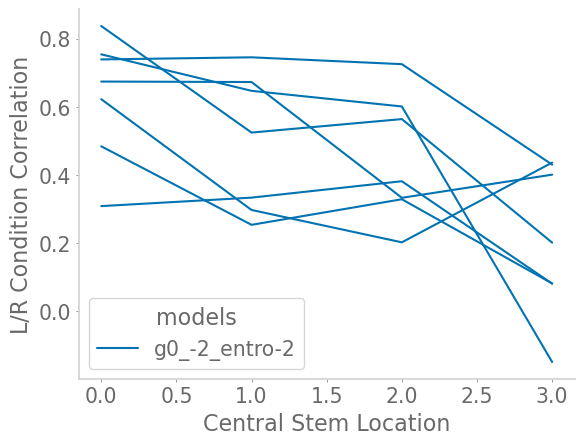

In [32]:
plt.figure()
sns.lineplot(
    x='stem_locs', y='splits', hue='models', data=dist_df,
    units='iteration', estimator=None
    )
plt.ylabel('L/R Condition Correlation')
plt.xlabel('Central Stem Location')
#plt.xticks([0, 2, 4], ['Reset', 'Middle', 'Decision Point'])
plt.show()

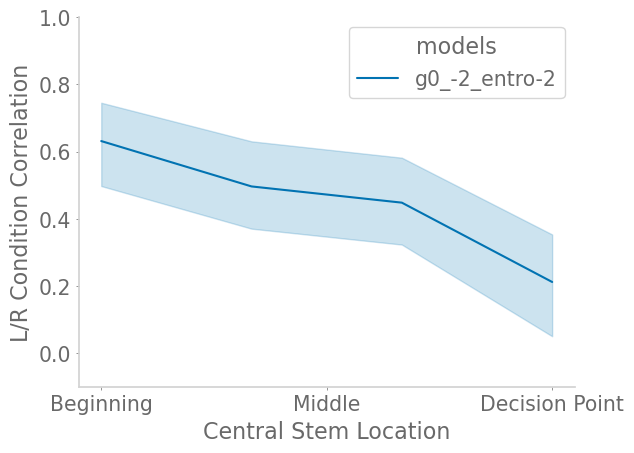

In [39]:
plt.figure()
sns.lineplot(
    x='stem_locs', y='splits', hue='models', data=dist_df
    )
plt.ylabel('L/R Condition Correlation')
plt.xlabel('Central Stem Location')

plt.ylim(-0.1, 1)
plt.xticks([0, 1.5, 3], ['Beginning', 'Middle', 'Decision Point'])
plt.show()

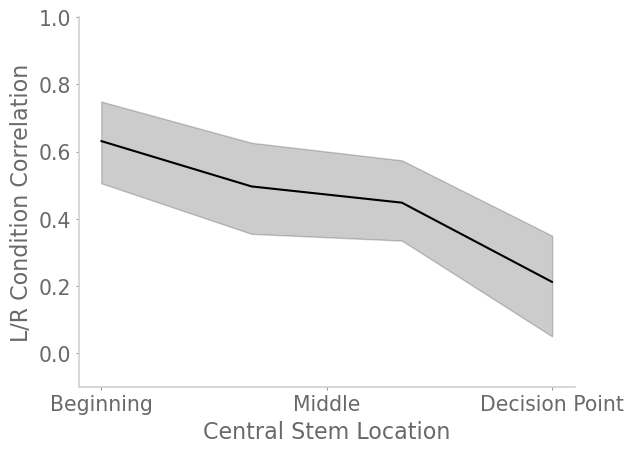

In [40]:
plt.figure()
sns.lineplot(
    x='stem_locs', y='splits', color='black', data=dist_df, 
    )
plt.ylabel('L/R Condition Correlation')
plt.xlabel('Central Stem Location')

plt.ylim(-0.1, 1)
plt.xticks([0, 1.5, 3], ['Beginning', 'Middle', 'Decision Point'])
plt.show()

# Plot 3D latents

In [11]:
model = f'g0_-2_entro-2'

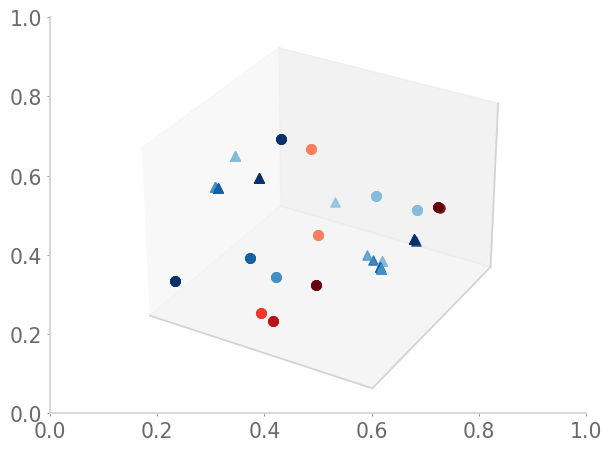

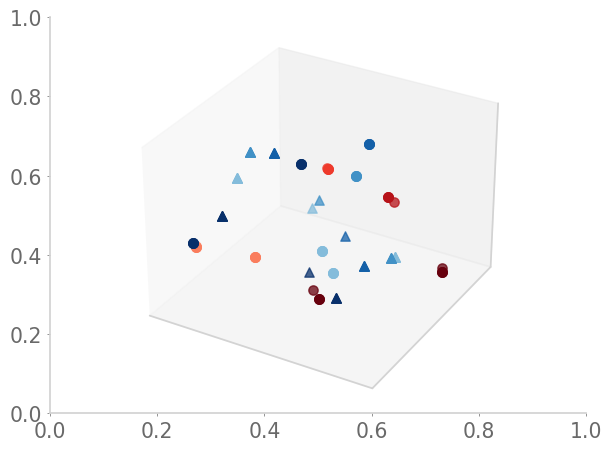

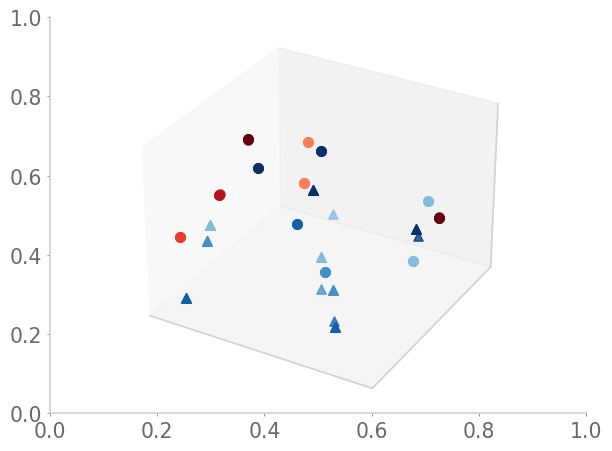

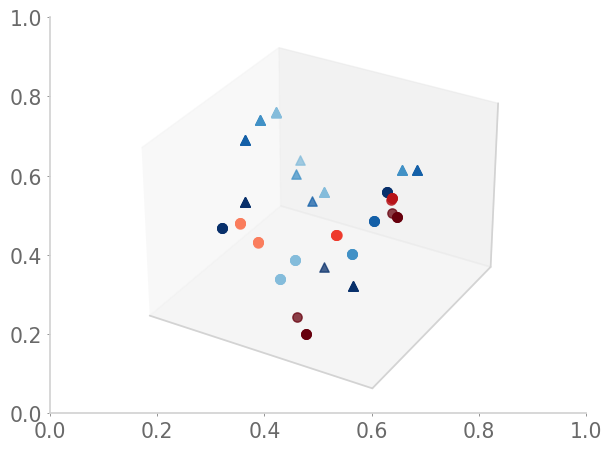

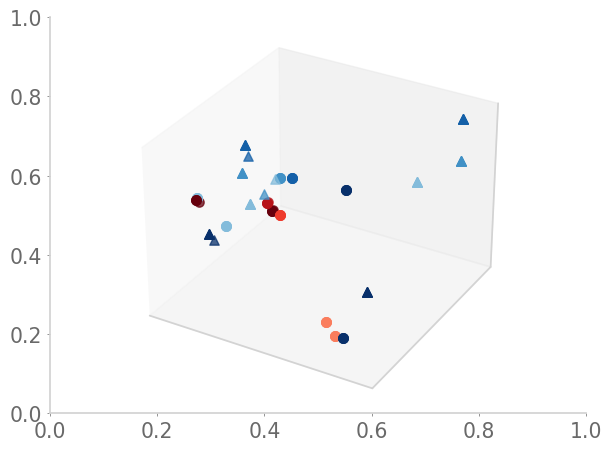

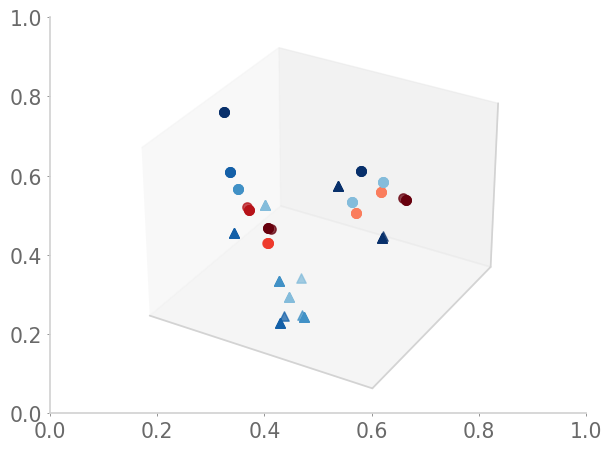

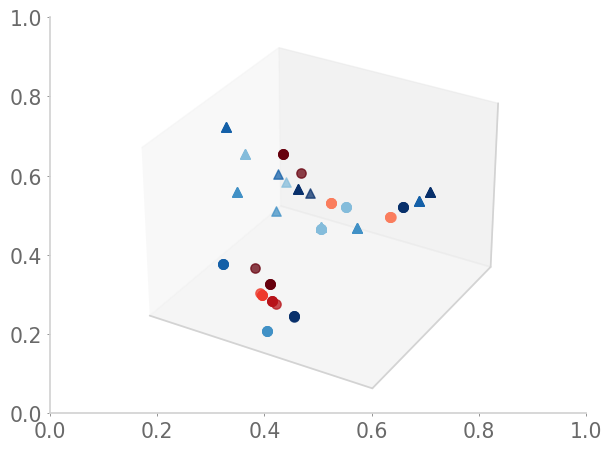

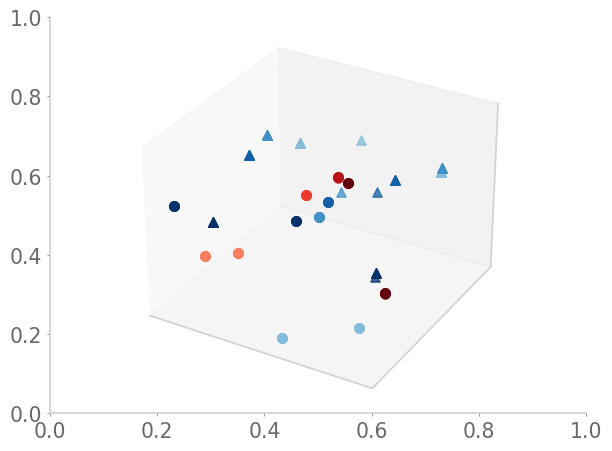

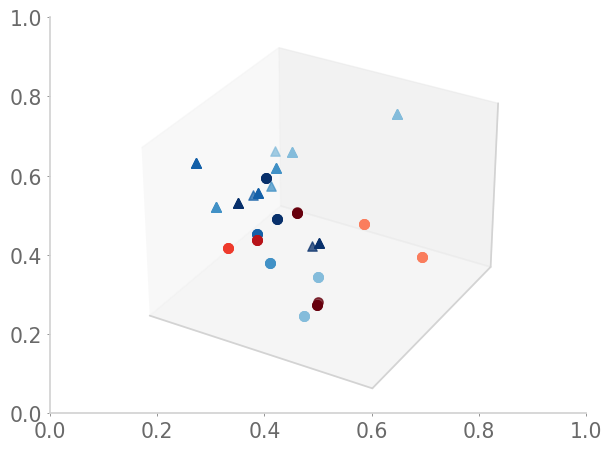

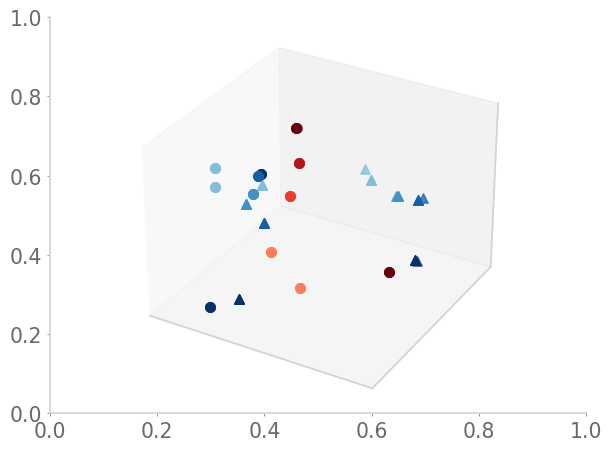

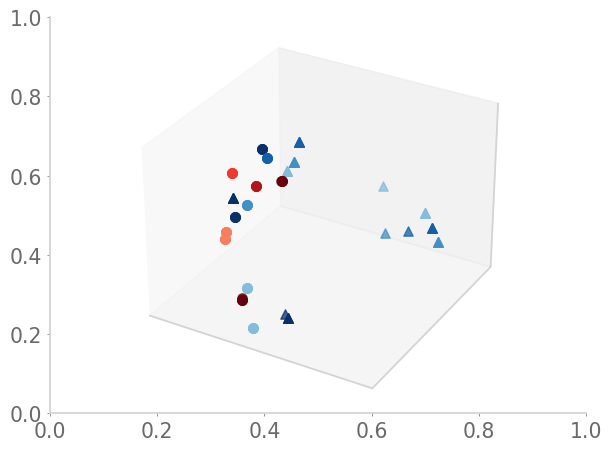

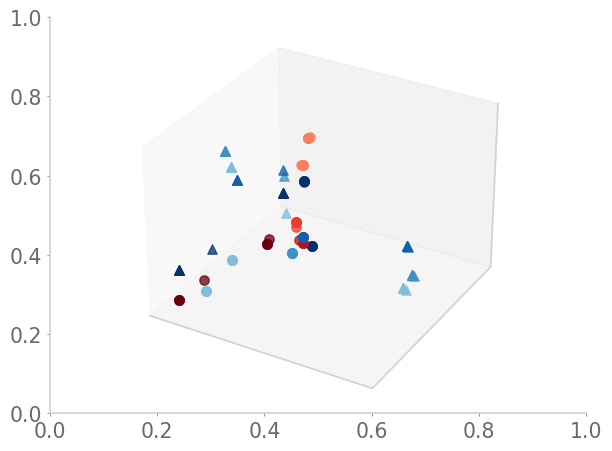

In [12]:
colors = ['C0', 'C1', 'C2', 'C3']
markers = ['s', '^', 'o']
iterations = np.unique(repr_df[repr_df['model']==model]['iteration'])
for i in iterations:
    _df = repr_df[(repr_df['model']==model) & (repr_df['iteration']==i)]
    final_reward = _df['final_reward'].iloc[0]
    if final_reward < 100: continue
    latents = np.array([x.tolist() for x in _df['latents']]).squeeze()
    reducer = PCA(n_components=3)
    reducer.fit(latents)
    reduced_latents = reducer.transform(latents)
    
    fig, ax = plt.subplots()
    ax = fig.add_subplot(111,projection='3d')
    colors = [cm.get_cmap('Reds'), cm.get_cmap('Blues'), cm.get_cmap('Blues')]
    color_steps = np.linspace(0.25, 1., y_locs.max()+1, endpoint=True)
    markers = ['s', '^', 'o']
    for i in np.arange(reduced_latents.shape[0]):
        condn_label = _df.iloc[i]['condn_label']
        maze_side = _df.iloc[i]['maze_side']
        reward_loc = _df.iloc[i]['reward_loc']
        x = _df.iloc[i]['x']
        y = _df.iloc[i]['y']
        if condn_label == 0: # Decision point
            color_step = color_steps[y]
            color = colors[reward_loc](color_step)
            marker = '^'
        elif (reward_loc < 3) and (maze_side == 0):
            color_step = color_steps[y]
            color = colors[reward_loc](color_step)
            marker = '^'
        elif maze_side < 0:
            color_step = color_steps[y]
            if y == 0:
                color = colors[1](color_step)
            else:
                color = colors[0](color_step)
            marker = 'o'
        elif maze_side > 0:
            color_step = color_steps[y]
            if y == 0:
                color = colors[0](color_step)
            else:
                color = colors[1](color_step)
            marker = 'o'
        else:
            print('error')
        ax.scatter(
            reduced_latents[i,0], reduced_latents[i,1], reduced_latents[i,2],
            color=color, marker=marker, alpha=0.75, s=45
            )
    plt.xticks([]);plt.yticks([])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.tight_layout()
    plt.savefig('altT_latents.png', dpi=300)
    plt.show()